# Visual Banana

https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md

## Setup

In [6]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
%matplotlib inline

In [56]:
%load_ext autoreload
%autoreload 2

from badaii.rl.agents.double_dqn import Agent
from badaii import helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Environment

In [2]:
env = UnityEnvironment(file_name="data/VisualBanana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

Number of agents: 1
Number of actions: 4
States look like:


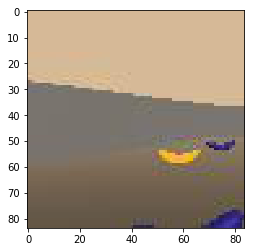

States have shape: (1, 84, 84, 3)


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

## Play Random Game
Watch an agent play randomly

In [6]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.visual_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.visual_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


## Agent

- 32 8x8 filters with stride 4 _ Relu
- 64 4x4 filters with stride 2 - ReLu
- 64 3x3 filters with stride 1 - ReLu 
- Fully Connected Layer with 1024 units - ReLu
- Fully Connected Layer with # of actions units

In [53]:
class QNetwork(nn.Module):
    def __init__(self, state_channels, action_size, seed):
        """
        
        """
        super(QNetwork, self).__init__()
        torch.manual_seed(seed)
        
        self.state_channels = state_channels
        self.action_size = action_size
        self.seed = seed
        
        # 32 8x8 filters with stride 4
        self.conv1 = nn.Conv2d(state_channels, 32, 8, stride=4)
        # 64 4x4 filters with stride 2 
        self.conv2 = nn.Conv2d(32,64,4, stride=2)
        # 64 3x3 filters with stride 1 
        self.conv3 = nn.Conv2d(64,64,3, stride=1)
        # 64x7x7, 1024
        self.fc1 = nn.Linear(64*7*7, 1024)
        # 1024, action_size
        self.fc2 = nn.Linear(1024, action_size)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(-1)))
        x = self.fc2(x)
        return x 

## Train

In [57]:
# Hyperparameters

In [82]:
m = QNetwork(3,action_size,0)
m_target = QNetwork(3, action_size, 0)

agent = Agent(m, m_target, action_size=4, seed=0)

In [83]:
agent.act(state.reshape(1, 3, 84, 84), epsilon=0.5)

> /Users/O0SA/Documents/git/banana-collector/Visual/badaii/rl/agents/double_dqn.py(80)act()
-> return np.random.choice(np.arange(self.action_size), p=probs)
(Pdb) probs
array([0.625, 0.125, 0.125, 0.125])
(Pdb) self.q_network(state)
tensor([ 0.0103,  0.0000,  0.0021, -0.0256], grad_fn=<ThAddBackward>)
(Pdb) q


BdbQuit: 